# Check emulator ability
Compare the performance of different emulators

In [25]:
# use observed streamflow data to evaluate model outputs
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, os, sys


# Load data

In [2]:
niter = 200
nparam = 27
params = np.nan * np.zeros([niter, nparam])

for i in range(0, niter):
    if i>=0:
        file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/SA_HH_allbasins/level1/param_sets/paramset_iter0_trial{i}.pkl'
    else:
        file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/SA_HH_allbasins/level1/param_sets/all_default_parameters.pkl' # -1: default paramters
        
    df_param = pd.read_pickle(file)
    va = df_param['Value'].values
    for j in range(nparam):
        params[i, j]=np.mean(va[j])

In [3]:
ngrid = 627
outpath = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/SA_HH_allbasins/level1/ctsm_outputs_evaluation'
kge = np.nan * np.zeros([niter, ngrid])
for t in range(0, niter): # -1 is default
    # outfile metric
    outfile_metric = f'{outpath}/metric_iter0_trial{t}.csv'
    df_metric = pd.read_csv(outfile_metric)
    kge[t, :] = df_metric['KGEmod'].values

In [4]:
index = ~np.isnan(kge[:,0])
kge = kge[index,:]
params = params[index,:]
kge.shape, params.shape

((179, 627), (179, 27))

# Emulator comparison

In [5]:
runbasin = 3

## random forest
Normalization Not Required

In [65]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Assuming `kge` and `params` are your datasets with shapes (179, 627) and (179, 27), respectively

# Split the kge dataset into 627 separate arrays, one for each basin
# Note: This step assumes `kge` is accessible as a numpy array or similar
kge_per_basin = np.split(kge, 627, axis=1)  # This splits along the second axis, resulting in 627 (179, 1) arrays

# Initialize a list to hold the cross-validation scores for each model/basin
cv_scores_rf = []

# For each basin, train a model and evaluate its performance using cross-validation
for basin_idx, kge_basin in enumerate(kge_per_basin):
    if np.mod(basin_idx, 50) == 0:
        print('processing basin', basin_idx)
        
    # Initialize the Random Forest regressor
    model = RandomForestRegressor()
    
    # Perform 5-fold cross-validation and store the mean score
    # Note: Adjust cv=5 to change the number of folds
    # Negative mean squared error is used as the scoring parameter; adjust as needed
    scores = cross_val_score(model, params, np.ravel(kge_basin), cv=5, scoring='neg_mean_squared_error')
    mean_score = np.mean(scores)
    
    # Store the mean score for this basin's model
    cv_scores_rf.append(mean_score)
    
    # # Optional: Print progress
    # print(f"Basin {basin_idx+1}: CV Score = {mean_score}")

    if basin_idx > runbasin:
        break

# cv_scores_rf now contains the cross-validation score for each basin's model
cv_scores_rf = np.array(cv_scores_rf)
print('mean cv_scores_rf', np.nanmean(cv_scores_rf))

processing basin 0
mean cv_scores_rf -0.017916634159768952
CPU times: user 5.97 s, sys: 16 ms, total: 5.99 s
Wall time: 12.9 s


## Gaussian process regression

In [21]:
%%time
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, Matern
from sklearn.model_selection import cross_val_score
import numpy as np

# Assuming `kge` and `params` are already loaded

# Split the kge dataset into 627 separate arrays, one for each basin
kge_per_basin = np.split(kge, 627, axis=1)

# Initialize a list to hold the cross-validation scores for each model/basin
cv_scores_gpr = []

# Define a kernel for the Gaussian Process using the Matérn kernel
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)

for basin_idx, kge_basin in enumerate(kge_per_basin):
    
    if np.mod(basin_idx, 50) == 0:
        print('processing basin', basin_idx)
        
    # Create a pipeline with normalization and GPR
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    pipeline = Pipeline([('normalize', MinMaxScaler()), ('gpr', gp)])
    
    # Perform 5-fold cross-validation and store the mean score
    scores = cross_val_score(pipeline, params, np.ravel(kge_basin), cv=5, scoring='neg_mean_squared_error')
    mean_score = np.mean(scores)
    
    # Store the mean score for this basin's model
    cv_scores_gpr.append(mean_score)

    # For demonstration, limit the number of basins processed
    if basin_idx > 2:  # Adjust this to process more or fewer basins
        break

cv_scores_gpr = np.array(cv_scores_gpr)
print('Mean CV scores GPR with normalization and Matérn kernel:', np.nanmean(cv_scores_gpr))

processing basin 0
Mean CV scores GPR with normalization and Matérn kernel: -0.01810396300358738
CPU times: user 6.58 s, sys: 19.8 ms, total: 6.6 s
Wall time: 7.05 s


## SVM

In [49]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import numpy as np

# Assuming `kge` and `params` are your datasets with shapes (179, 627) and (179, 27), respectively

# Split the kge dataset into 627 separate arrays, one for each basin
kge_per_basin = np.split(kge, 627, axis=1)  # This splits along the second axis, resulting in 627 (179, 1) arrays

# Initialize a list to hold the cross-validation scores for each model/basin
cv_scores_svm = []

# For each basin, train a Support Vector Regression model and evaluate its performance using cross-validation
for basin_idx, kge_basin in enumerate(kge_per_basin):

    if np.mod(basin_idx, 50) == 0:
        print('processing basin', basin_idx)
    
    # Initialize the SVR model within a pipeline that includes normalization
    svr_pipeline = make_pipeline(StandardScaler(), SVR(kernel='rbf'))
    
    # Perform 5-fold cross-validation and store the mean score
    # Note: Adjust cv=5 to change the number of folds
    # Negative mean squared error is used as the scoring parameter; adjust as needed
    scores = cross_val_score(svr_pipeline, params, np.ravel(kge_basin), cv=5, scoring='neg_mean_squared_error')
    mean_score = np.mean(scores)
    
    # Store the mean score for this basin's model
    cv_scores_svm.append(mean_score)
    
    # Optional: Print progress
    if basin_idx > runbasin:  # Early break for demonstration purposes
        break

# cv_scores_svm now contains the cross-validation score for each basin's model
cv_scores_svm = np.array(cv_scores_svm)
print('mean cv_scores_svm', np.nanmean(cv_scores_svm))


processing basin 0
mean cv_scores_svm -0.02236118670705224


## ANN

In [51]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import numpy as np

# Assuming `kge` and `params` are already loaded with shapes (179, 627) and (179, 27), respectively

# Split the kge dataset into 627 separate arrays, one for each basin
kge_per_basin = np.split(kge, 627, axis=1)

# Initialize a list to hold the cross-validation scores for each model/basin
cv_scores_mlp = []

# Loop through each basin
for basin_idx, kge_basin in enumerate(kge_per_basin):

    if np.mod(basin_idx, 50) == 0:
        print('processing basin', basin_idx)

    # Create an MLPRegressor with adjusted parameters
    mlp = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', 
                       alpha=0.001, batch_size='auto', learning_rate='adaptive', 
                       learning_rate_init=0.001, max_iter=1000, shuffle=True, 
                       random_state=1, tol=0.0001, verbose=False, early_stopping=True, 
                       validation_fraction=0.1, n_iter_no_change=10)
    
    # Use a pipeline to automate scaling
    pipeline = make_pipeline(StandardScaler(), mlp)
    
    # Perform cross-validation
    # Ensure kge_basin is flattened properly to match the shape of params
    scores = cross_val_score(pipeline, params, kge_basin.flatten(), cv=5, scoring='neg_mean_squared_error')
    mean_score = np.mean(scores)

    # Append the mean score to the list
    cv_scores_mlp.append(mean_score)

    # Stop early for the sake of demonstration
    if basin_idx > runbasin:
        break

# Convert the scores list to a NumPy array for convenience
cv_scores_mlp = np.array(cv_scores_mlp)
print('Mean CV Scores for MLP:', np.nanmean(cv_scores_mlp))

processing basin 0
Mean CV Scores for MLP: -0.05339818461894081


## MO-ASMO GPR

In [6]:
import sys
sys.path.append('../../../ctsm_optz/MO-ASMO/src')
from gp import *

In [9]:
%%time
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import numpy as np

# Sample data setup -- replace with your actual data
# params = np.random.randn(179, 27)  # Example feature matrix
# kge = np.random.randn(179, 627)    # Example target matrix

n_splits = 5  # Number of folds for cross-validation
kf = KFold(n_splits=n_splits)

# Assuming the bounds for the GPR_Matern class are known
xlb = np.min(params, axis=0)
xub = np.max(params, axis=0)

cv_scores_mgpr = []

# Process each basin separately
for basin_index in range(kge.shape[1]):

    if np.mod(basin_index, 50) == 0:
        print('processing basin', basin_index)
        
    basin_scores = []
    y = kge[:, basin_index]

    for train_index, test_index in kf.split(params):
        X_train, X_test = params[train_index], params[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Initialize and fit the GPR_Matern model
        model = GPR_Matern(X_train, y_train, nInput=27, nOutput=1, N=len(train_index), xlb=xlb, xub=xub)
        
        # Predict using the fitted model
        y_pred = model.predict(X_test)
        
        # Calculate the negative mean squared error
        score = -mean_squared_error(y_test, y_pred)
        
        basin_scores.append(score)
    
    # Output the average score for the basin
    avg_score = np.mean(basin_scores)

    # Append the mean score to the list
    cv_scores_mgpr.append(avg_score)
    

# Convert the scores list to a NumPy array for convenience
cv_scores_mgpr = np.array(cv_scores_mgpr)
print('Mean CV Scores for MOASMO GPR:', np.nanmean(cv_scores_mgpr))

np.savez_compressed('cv_scores_mgpr.npz', cv_scores_mgpr=cv_scores_mgpr)

processing basin 0
processing basin 50
processing basin 100
processing basin 150
processing basin 200
processing basin 250
processing basin 300
processing basin 350
processing basin 400
processing basin 450
processing basin 500
processing basin 550
processing basin 600
Mean CV Scores for MOASMO GPR: -1.4720670926998025
CPU times: user 23min 20s, sys: 509 ms, total: 23min 20s
Wall time: 48min 42s


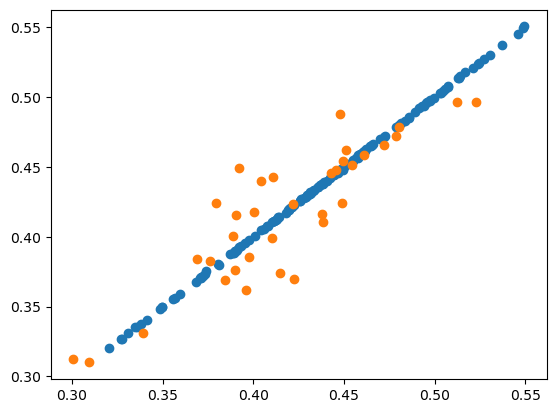

In [23]:
plt.scatter(model.predict(X_train), y_train)
plt.scatter(model.predict(X_test), y_test)